In [1]:
## This is demo for kuka reaching a desired point with diff_qp
## Author : Avadesh Meduri
## Date : 25/02/2022
import time
import numpy as np
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

from diff_pin_costs import DiffFrameTranslationCost, DiffFrameVelocityCost
from inverse_qp import IOC

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.nn import functional as F
from torch.utils.data import DataLoader

from tqdm import trange

In [2]:
robot = IiwaConfig.buildRobotWrapper()
model, data = robot.model, robot.data
f_id = model.getFrameId("EE")

In [3]:
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [4]:
dtc = DiffFrameTranslationCost.apply
dvc = DiffFrameVelocityCost.apply

def quadratic_loss(q_pred, x_des, nq, n_col):
    loss = 3.5e1*torch.linalg.norm(dtc(q_pred[-2*nq:], model, data, f_id) - x_des)
    loss += 1.5e0*torch.linalg.norm(dvc(q_pred[-2*nq:], torch.zeros(nq), model, data, f_id)) # asking for zero velocity
    loss += 5e-3*torch.linalg.norm(q_pred[-2*nq:-nq]) # joint regularization
    
    for i in range(n_col):    
        loss += 1e0*torch.linalg.norm(dtc(q_pred[(3*i)*nq: (3*i+2)*nq], model, data, f_id) - x_des)
        loss += 5e-1*torch.linalg.norm(dvc(q_pred[(3*i)*nq: (3*i+2)*nq], q_pred[(3*i+2)*nq:(3*i+3)*nq], model, data, f_id)) # asking for zero velocity
        loss += 1e-2*torch.linalg.norm(q_pred[(3*i+2)*nq: (3*i+3)*nq]) # control regularization
        loss += 2e-1*torch.linalg.norm(q_pred[(3*i+1)*nq: (3*i+2)*nq]) # velocity regularization
        loss += 3e-3*torch.linalg.norm(q_pred[(3*i)*nq: (3*i+1)*nq]) # joint regularization
        
        if i < n_col - 1:
            loss += 5e-2*torch.linalg.norm(torch.subtract(q_pred[(3*i+2)*nq: (3*i+3)*nq], \
                                                          q_pred[(3*i+5)*nq: (3*i+6)*nq]))
        if i == n_col - 1:
            # terminal joint velocity regularization
            loss += 2e-1*torch.linalg.norm(q_pred[(3*i+1)*nq: (3*i+2)*nq]) 

    return loss

In [5]:
nq = model.nq
nv = model.nv
q0 = [np.pi/16.0, -np.pi/16.0, 0, 0, 0, 0, 0]
x_init = np.concatenate([q0, pin.utils.zero(model.nv)])

n_col = 5
u_max = [2.5, 2.5, 2.5, 1.5, 1.5, 1.5, 1.0]
dt = 0.05

isvec = True
lr_qp = 1e-1
max_eps = 100

In [6]:
buffer_size = 4096

x_train_init = torch.zeros((buffer_size,len(x_init)))
x_train_des = torch.zeros((buffer_size, 3))

n_vars = 3*nq*n_col + 2*nq
if not isvec:
    y_train = torch.zeros((buffer_size, n_vars**2 + n_vars))
else:
    y_train = torch.zeros((buffer_size, 2*n_vars))

In [7]:
def sample_next_location(curr_location):
    lb = torch.tensor([0.4,  0.4, 0.0])
    ub = torch.tensor([1.0,  1.0, 1.1])
    diff_range = 1.6
    dist_ub = 0.8
    dist_lb = 0.4

    while True:
        diff = diff_range * (torch.rand(3) - 0.5)
        next_location = curr_location + diff
        if (all(next_location >= lb) 
            and all(next_location <= ub) 
            and torch.linalg.norm(next_location) >= dist_lb
            and torch.linalg.norm(next_location) <= dist_ub): 
            break
    return next_location

In [8]:
# generate data
visualize = True
all_x_des = []
for k in trange(buffer_size):
    ioc = IOC(n_col, nq, u_max, dt, eps = 1.0, isvec=isvec)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr_qp)

    if k % 32 == 0:
        x_init = np.zeros(2 * nq)
        if k < 1:
            x_des = torch.tensor([0.6, 0.4, 0.7])
            x_init[:nq] = np.array([0.0, 0.3, 0.0, -0.8, -0.6,  0.0, 0.0])
        else:
            x_des = sample_next_location(x_des.detach())
            x_init[:nq] = x_pred[-2*nq:-nq] + 0.4 * (np.random.rand(nq) - 0.5)
    
        x_init[nq:] = 0.8 * (np.random.rand(nv) - 0.5) 
        all_x_des.append(x_des.detach().clone())
            
        if visualize:
            viz.display(x_init[:nq])
            viz.viewer["box"].set_object(g.Sphere(0.05), 
                             g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
            viz.viewer["box"].set_transform(tf.translation_matrix(x_des.detach().numpy()))
    else:
        x_init = x_pred[-2*nq:]

    x_train_init[k] = torch.tensor(x_init)
    x_train_des[k] = x_des
    
    i = 0
    loss = 1000.
    old_loss = 10000.
    
    while loss > 0.03 and i < max_eps and abs(old_loss - loss) > 5e-4:
        x_pred = ioc(x_init) 
        old_loss = loss
        loss = quadratic_loss(x_pred, x_des, nq, n_col)
#         print("Index :" + str(k) + "/" + str(buffer_size) + " Iteration :" + str(i) + "/" + str(max_eps) +  " loss is : " + str(loss.detach().numpy()), end = '\r', flush = True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    
    x_pred = ioc(x_init).detach().numpy()
    if visualize:
        for i in range(n_col+1):
            q = x_pred[3*nq*i:3*nq*i + nq]
            dq = x_pred[3*nq*i + nq:3*nq*i + 2*nq]

            pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
            pin.updateFramePlacements(model, data)
            viz.display(q)
            time.sleep(0.01)
    # storing the weights and x_nom
    y_train[k] = torch.hstack((ioc.weight.flatten(), ioc.x_nom))

100%|██████████| 4096/4096 [33:50<00:00,  2.02it/s]


In [9]:
x_train = torch.hstack((x_train_init, x_train_des)).float()
y_train = y_train.detach().float()
data_train = list(zip(x_train, y_train))
torch.save(data_train, "./data/data_train.pt")

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        # game params
        super().__init__()
        
        self.swish = nn.SiLU()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.dropout = nn.Dropout(p=0.5)

        self.out = nn.Linear(512, output_size)
        
    def forward(self, x):
        
        x = self.swish(self.bn1(self.fc1(x)))
        x = self.dropout(self.swish(self.bn2(self.fc2(x)))) 
        x = self.swish(self.bn3(self.fc3(x)))
        x = self.out(x)

        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = Net(x_train.shape[1], y_train.shape[1]).to(device).train()
lr_nn = 1e-3
batch_size = 64
optimizer = torch.optim.Adam(net.parameters(), lr=lr_nn)
l1_loss = torch.nn.L1Loss()

train_dataloader = DataLoader(data_train, batch_size=128, 
                              shuffle=True)

for epoch in trange(5000):
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = l1_loss(y_pred, y) 
        loss.backward()
        optimizer.step()
    if epoch % 1000 == 0:
        print(loss)

  0%|          | 4/5000 [00:00<05:09, 16.14it/s]

tensor(0.3414, device='cuda:0', grad_fn=<L1LossBackward0>)


 20%|██        | 1002/5000 [02:11<08:59,  7.41it/s]

tensor(0.1638, device='cuda:0', grad_fn=<L1LossBackward0>)


 40%|████      | 2002/5000 [04:10<06:38,  7.52it/s]

tensor(0.1581, device='cuda:0', grad_fn=<L1LossBackward0>)


 60%|██████    | 3002/5000 [06:17<04:18,  7.73it/s]

tensor(0.1567, device='cuda:0', grad_fn=<L1LossBackward0>)


 80%|████████  | 4002/5000 [08:00<02:08,  7.74it/s]

tensor(0.1523, device='cuda:0', grad_fn=<L1LossBackward0>)


100%|██████████| 5000/5000 [10:01<00:00,  8.32it/s]


In [12]:
net = net.cpu().eval()
x_train = x_train.cpu()
y_train = y_train.cpu()

In [62]:
# visualize the init configuration and the desired location for a random data point
k = np.random.randint(buffer_size)
k = 1473
x_in = x_train[k].clone().detach()
y = y_train[k].clone().detach()

q_init = x_in[:nq].numpy()
x_des = x_in[-3:]

print(k)
print(x_des)

viz.viewer["box"].set_object(g.Sphere(0.05), 
                         g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
viz.viewer["box"].set_transform(tf.translation_matrix(x_des[-3:].detach().numpy()))
viz.display(q_init)

1473
tensor([0.5711, 0.4774, 0.1610])


In [63]:
for j in range(50):
    ioc = IOC(n_col, nq, u_max, dt, eps = 1.0, isvec=isvec)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr_qp)
    pred = net(x_in[None,:]).squeeze()
    
    if not isvec:
        ioc.weight = torch.nn.Parameter(torch.reshape(pred[0:n_vars**2], (n_vars, n_vars)))
        ioc.x_nom = torch.nn.Parameter(pred[n_vars**2:])
    else:
        ioc.weight = torch.nn.Parameter(pred[0:n_vars])
        ioc.x_nom = torch.nn.Parameter(pred[n_vars:])

#         print(torch.relu(ioc.weight)*ioc.x_nom)
#         print("--------------------------------------------------")
    x_pred = ioc((x_in[:-3]).detach().numpy()) 
    x_pred = x_pred.detach().numpy()

    for i in range(n_col+1):
        q = x_pred[3*nq*i:3*nq*i + nq]
        dq = x_pred[3*nq*i + nq:3*nq*i + 2*nq]

        pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
        pin.updateFramePlacements(model, data)

        viz.display(q)
        time.sleep(0.05)
    
    x_in[0:2*nq] = torch.tensor(x_pred[-2*nq:])
#     print(x_pred[-nq:])

In [15]:
torch.save(net.state_dict(), "./models/test2")
print("saved ...")

saved ...


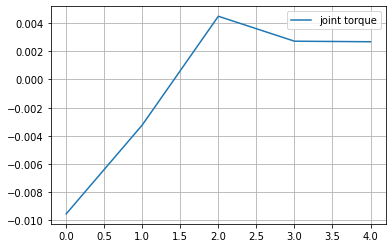

In [16]:
from matplotlib import pyplot as plt

plt.plot(x_pred[2*nq + 1:: 3*nq], label = "joint torque")
plt.legend()
plt.grid()

In [17]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,0], label = "x_pos")
plt.grid()
plt.legend()

NameError: name 'plt_des' is not defined

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,1], label = "y_pos")
plt.grid()
plt.legend()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,2], label = "z_pos")
plt.grid()
plt.legend()

In [ ]:
from mim_data_utils import DataLogger, DataReader
reader = DataReader('test.mds')

for i in range(len(reader.data['joint_positions'])):
    q = reader.data['joint_positions'][i]
    viz.display(q)
#     time.sleep(0.05)

In [ ]:
x_train[0]